# Imports

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from Evaluation import compute_clusters, compute_purity, compute_recall, compute_f1, compute_entropy

# Reading Data from Text Files

In [2]:
data_directory = "data"
training_data_means = []
evaluation_data_means = []
flattened_training_data = []
flattened_evaluation_data = []
training_labels = []
evaluation_labels = []

# Step 1: Accessing the Data Directory
activities = os.listdir(data_directory)

# Step 2: Iterating Through Activity Folders
for activity in activities:
    activity_path = os.path.join(data_directory, activity)
    activity_number = int(activity.split("a")[1])
    
    print("Activity Number:", activity_number)
    print("Activity:", activity)
    training_labels.extend([activity_number] * 48 * 8)  # 48 segments for training
    evaluation_labels.extend([activity_number] * 12 * 8)  # 12 segments for evaluation
    
    
    # Step 3: Iterating Through Subject Folders
    subjects = os.listdir(activity_path)
    for subject in subjects:
        subject_path = os.path.join(activity_path, subject)
        
        # Step 4: Reading Text Files (Segments)
        segments = os.listdir(subject_path)
        training_segments = segments[:48]  # First 48 segments for training
        evaluation_segments = segments[48:]  # Rest for evaluation
        
        for segment_file in training_segments:
            segment_file_path = os.path.join(subject_path, segment_file)
            with open(segment_file_path, 'r') as file:
                segment_data = np.loadtxt(file, delimiter=',')
                mean_data = np.mean(segment_data, axis=0)  # Taking mean along columns
                training_data_means.append(mean_data)
                
                flattened_data = segment_data.flatten()  # Flattening the segment
                flattened_training_data.append(flattened_data)
        
        for segment_file in evaluation_segments:
            segment_file_path = os.path.join(subject_path, segment_file)
            with open(segment_file_path, 'r') as file:
                segment_data = np.loadtxt(file, delimiter=',')
                mean_data = np.mean(segment_data, axis=0)  # Taking mean along columns
                evaluation_data_means.append(mean_data)
                
                flattened_data = segment_data.flatten()  # Flattening the segment
                flattened_evaluation_data.append(flattened_data)

# Convert the data lists into numpy arrays
training_data_means = np.array(training_data_means)
evaluation_data_means = np.array(evaluation_data_means)
flattened_training_data = np.array(flattened_training_data)
flattened_evaluation_data = np.array(flattened_evaluation_data)
PCA_training_data = PCA(n_components=0.9).fit_transform(flattened_training_data)
PCA_evaluation_data = PCA(n_components=0.9).fit_transform(flattened_evaluation_data)

Activity Number: 1
Activity: a01
Activity Number: 2
Activity: a02
Activity Number: 3
Activity: a03
Activity Number: 4
Activity: a04
Activity Number: 5
Activity: a05
Activity Number: 6
Activity: a06
Activity Number: 7
Activity: a07
Activity Number: 8
Activity: a08
Activity Number: 9
Activity: a09
Activity Number: 10
Activity: a10
Activity Number: 11
Activity: a11
Activity Number: 12
Activity: a12
Activity Number: 13
Activity: a13
Activity Number: 14
Activity: a14
Activity Number: 15
Activity: a15
Activity Number: 16
Activity: a16
Activity Number: 17
Activity: a17
Activity Number: 18
Activity: a18
Activity Number: 19
Activity: a19


# Display Data

In [3]:
# Now, 'training_data_means' and 'evaluation_data_means' contain mean values of each column for each segment,
# and 'flattened_training_data' and 'flattened_evaluation_data' contain flattened data for each segment.
print("Shape of training labels", np.array(training_labels).shape)
print("Shape of evaluation labels", np.array(evaluation_labels).shape)
print("Shape of training data (means):", training_data_means.shape)
print("Shape of evaluation data (means):", evaluation_data_means.shape)
print("Shape of flattened training data:", flattened_training_data.shape)
print("Shape of flattened evaluation data:", flattened_evaluation_data.shape)
print("Shape of PCA training data:", PCA_training_data.shape)
print("Shape of PCA evaluation data:", PCA_evaluation_data.shape)

Shape of training labels (7296,)
Shape of evaluation labels (1824,)
Shape of training data (means): (7296, 45)
Shape of evaluation data (means): (1824, 45)
Shape of flattened training data: (7296, 5625)
Shape of flattened evaluation data: (1824, 5625)
Shape of PCA training data: (7296, 342)
Shape of PCA evaluation data: (1824, 203)


In [4]:
pd.DataFrame(training_labels)

,0
0,1
1,1
2,1
3,1
4,1
...,...
7291,19
7292,19
7293,19
7294,19


In [5]:
pd.DataFrame(evaluation_labels)

,0
0,1
1,1
2,1
3,1
4,1
...,...
1819,19
1820,19
1821,19
1822,19


In [6]:
pd.DataFrame(training_data_means)

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,7.975714,1.083150,5.606846,0.004897,0.026123,-0.003726,-0.790726,-0.068490,0.135897,0.679134,...,-0.035894,-2.814833,-9.085131,2.618207,-0.005036,0.002166,-0.003155,0.739615,0.301314,-0.057119
1,7.978250,1.140865,5.598922,0.003308,0.022514,-0.003240,-0.791962,-0.070157,0.137123,0.644964,...,-0.036834,-2.812867,-9.082297,2.624948,-0.004721,0.001699,-0.003727,0.740610,0.301896,-0.057268
2,7.970894,1.140962,5.607750,0.001846,0.018806,-0.003486,-0.792875,-0.070723,0.136436,0.608212,...,-0.038748,-2.807500,-9.082531,2.627137,-0.005584,0.001496,-0.003810,0.740970,0.302462,-0.057068
3,7.938412,1.165260,5.648969,0.003788,0.023768,-0.003512,-0.793550,-0.071969,0.131983,0.591138,...,-0.039665,-2.814711,-9.080514,2.629053,-0.006103,0.002277,-0.003669,0.741128,0.302388,-0.056422
4,7.908930,1.187504,5.680980,0.001086,0.012242,-0.002488,-0.793872,-0.072597,0.128345,0.558168,...,-0.039774,-2.811185,-9.082110,2.624799,-0.004796,0.001837,-0.002592,0.741038,0.302977,-0.055801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7291,9.636061,-0.817827,0.666605,-0.166818,0.169352,-0.102916,-0.706365,0.223675,0.178247,3.288036,...,0.428232,-10.141740,-0.963973,-1.014032,0.121843,0.217958,0.040094,0.693697,-0.165776,-0.077733
7292,9.208050,-0.028595,0.035554,-0.252890,-0.232438,0.070761,-0.712689,-0.332383,0.251540,8.854872,...,-0.085556,-9.868485,-1.063173,-0.387856,0.221960,-0.030719,0.126698,0.716365,-0.148170,0.375404
7293,9.085391,-0.729566,-1.186151,0.004378,0.100392,-0.197931,-0.684232,-0.013913,0.447402,4.768502,...,0.247806,-9.728274,-1.066991,-0.916056,-0.105329,0.134909,-0.103218,0.706763,-0.286951,0.112680
7294,9.252281,-0.822683,0.074980,-0.127898,-0.085208,0.086088,-0.743356,-0.408631,-0.091266,7.935659,...,-0.282472,-9.725768,-0.638715,-0.476301,0.112858,-0.051090,0.076192,0.630075,0.168104,0.523236


In [7]:
pd.DataFrame(evaluation_data_means)

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,7.854082,1.456251,5.694497,0.003143,0.019895,-0.003625,-0.792749,-0.079225,0.126838,0.156108,...,-0.041449,-2.773110,-9.097752,2.622869,-0.005791,0.002850,-0.003841,0.739407,0.304723,-0.056929
1,7.818099,1.462787,5.751147,0.001973,0.018319,-0.003239,-0.792798,-0.078748,0.121525,0.142965,...,-0.041341,-2.766255,-9.104143,2.615004,-0.005679,0.001721,-0.002426,0.738331,0.305401,-0.057062
2,7.809022,1.462826,5.754360,0.004406,0.025226,-0.003796,-0.791802,-0.078422,0.120485,0.148502,...,-0.041566,-2.774948,-9.100124,2.613834,-0.005993,0.001737,-0.002673,0.737764,0.303699,-0.057008
3,7.814455,1.482194,5.747409,0.000910,0.016790,-0.003389,-0.790146,-0.078166,0.121009,0.133379,...,-0.041223,-2.776000,-9.102172,2.611489,-0.004303,0.001911,-0.003268,0.736539,0.303044,-0.057341
4,7.822188,1.482432,5.728115,0.003867,0.023562,-0.003863,-0.790796,-0.078869,0.122690,0.128382,...,-0.041219,-2.775946,-9.101374,2.610259,-0.004588,0.003073,-0.002962,0.737319,0.303537,-0.057092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1819,8.280854,-1.491537,-1.810327,-0.207825,0.000424,-0.033526,-0.743045,-0.232313,-0.205412,8.690373,...,-0.198048,-9.514857,-1.029346,-0.173410,0.197243,0.099143,-0.017317,0.687913,0.522945,0.297666
1820,9.591118,0.086304,0.953378,-0.282265,0.036106,-0.032716,-0.621380,-0.160003,-0.535185,6.477090,...,-0.064055,-10.192544,-0.766219,-1.774920,0.094482,0.030991,-0.022373,0.640863,0.498228,0.224716
1821,9.599113,-0.728367,0.746111,0.379479,0.009941,0.084331,-0.699988,0.344679,-0.252860,6.309986,...,0.640837,-10.457773,-0.858208,-1.934268,-0.232521,-0.012902,-0.086963,0.773123,0.145656,-0.237786
1822,9.692482,-0.582724,0.758863,0.056271,0.057337,-0.030570,-0.764581,-0.438206,-0.075430,5.020496,...,-0.192422,-9.946800,-1.160466,-0.334505,-0.209831,-0.036731,-0.028740,0.714388,0.157381,0.533023


In [8]:
pd.DataFrame(PCA_training_data)

,0,1,2,3,4,5,6,7,8,9,...,332,333,334,335,336,337,338,339,340,341
0,117.479780,-15.081878,-25.262451,20.161103,-17.202622,1.507880,-2.091883,-7.672715,-69.638233,21.164041,...,0.223474,0.432996,-0.133751,-0.242972,-0.437970,0.159149,0.212670,0.088582,0.691092,-0.221120
1,117.192437,-15.270750,-24.675299,20.983118,-17.987284,1.611497,-2.099562,-7.661477,-69.573759,21.143386,...,0.177481,0.406242,-0.074422,-0.209429,-0.379948,0.003045,0.052372,0.307355,0.709612,-0.408416
2,117.335477,-15.291009,-23.907791,21.479542,-18.375017,1.730878,-2.199927,-7.716655,-69.734015,21.191607,...,0.126475,0.355690,-0.096131,-0.312287,-0.378337,0.134514,0.092304,0.207380,0.697389,-0.368035
3,117.483758,-15.456825,-23.623990,22.021948,-18.174414,1.681469,-2.174942,-7.765298,-69.482586,21.131655,...,0.144077,0.398790,-0.144767,-0.284755,-0.456203,0.157881,0.058852,0.131351,0.730133,-0.340523
4,117.874571,-15.652052,-23.193157,22.421622,-17.969986,1.734918,-2.224690,-7.702666,-69.325452,21.113117,...,0.174106,0.402751,-0.156543,-0.268058,-0.350911,0.117443,0.097502,0.173928,0.626771,-0.359934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7291,-44.555917,-11.404959,21.950198,-34.574760,10.483557,6.505011,2.394975,-0.589461,0.968893,13.079053,...,-12.223740,-0.158059,-3.036723,-10.815120,-0.265284,-17.737252,-0.074645,-14.433232,17.841659,0.621895
7292,-92.722280,10.527358,-40.322598,-9.608462,0.847616,6.751602,2.222593,-9.240928,-3.330877,16.068835,...,-6.698948,5.445352,14.294927,17.159822,3.730198,18.311282,15.270597,6.745702,5.466236,-6.596172
7293,-71.847502,-2.191509,-0.883760,-7.090788,-15.144780,-19.809343,7.476723,12.028284,-10.728885,-5.730117,...,-19.277540,-6.585787,-7.374586,0.808126,15.192388,-1.538078,1.548771,-14.871527,-12.459866,18.149437
7294,-76.983524,19.312910,-35.938152,-29.550184,14.499609,0.438128,-4.591097,5.089399,-5.013416,-1.357255,...,-9.616858,-3.499501,3.951223,-9.332422,2.509560,3.652877,3.890029,-5.265612,-13.716344,-0.862646


In [9]:
pd.DataFrame(PCA_evaluation_data)

,0,1,2,3,4,5,6,7,8,9,...,193,194,195,196,197,198,199,200,201,202
0,121.741276,-18.532317,-18.233717,21.990107,23.721718,0.265593,5.337134,-0.598922,-5.842693,-62.848456,...,0.612035,-0.527682,0.080910,0.375347,-0.454238,-0.518405,1.426334,2.182644,0.009885,-1.309071
1,122.041239,-18.488867,-18.113113,22.451534,23.324605,0.236997,5.292676,-0.614789,-5.879359,-62.755095,...,0.595439,-0.506615,0.121885,0.403650,-0.435799,-0.570529,1.385562,2.204678,0.021310,-1.252997
2,121.872674,-18.526802,-18.091153,22.649315,23.351816,0.270824,5.305729,-0.623641,-5.835910,-62.671009,...,0.571297,-0.537637,0.091379,0.359836,-0.482373,-0.588050,1.401923,2.240951,-0.015752,-1.166439
3,121.944404,-18.780667,-18.118332,22.632365,23.383787,0.285732,5.327630,-0.594685,-5.850094,-62.537639,...,0.550011,-0.459967,0.101057,0.410288,-0.455461,-0.541990,1.460564,2.146773,-0.006432,-1.324044
4,121.850191,-18.804005,-18.025001,22.572894,23.593152,0.259667,5.335662,-0.613675,-5.842390,-62.549254,...,0.515170,-0.461316,0.115383,0.329856,-0.472310,-0.502434,1.437395,2.191698,0.012258,-1.318657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1819,-88.433229,25.004018,-23.990770,-11.103473,11.533247,5.345518,-21.754606,10.184293,-0.525775,-23.073820,...,2.340520,12.860884,7.926100,-5.585449,11.667149,-14.122488,-3.588444,1.823093,-14.097295,12.795439
1820,-68.281484,-27.633038,2.307251,-1.350261,5.669564,-2.477249,-9.057184,11.760181,8.734326,-0.488101,...,3.901033,-23.373910,3.612246,6.300962,-3.231341,-0.796622,-2.808663,20.964061,21.341616,-14.733299
1821,-53.621818,-28.630010,28.423740,-23.917304,5.035024,-116.018057,-62.499976,22.119515,14.885649,-2.937969,...,13.600511,-4.850673,7.293286,-5.890819,11.822259,-7.822333,-20.584790,21.346809,1.026828,-22.151720
1822,-51.191511,-21.206067,11.404257,-21.908929,4.032080,-0.845348,-16.931145,34.517105,18.061085,12.129647,...,-9.085684,-7.279893,19.399398,2.193473,1.551502,-1.891928,-24.287589,9.248219,-2.366426,9.531351


# Kmeans Clustering implementation

In [10]:
class Kmeans:
    def __init__(self, n_clusters, max_iter=300, tol=1e-4):
        self.centroids = None
        self.cluster_centers_ = None
        self.clusters = None
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.inertia_ = None
        np.random.seed(42)

    def fit(self, data):
        # Initialize centroids randomly
        clusters = None
        centroids_idx = np.random.choice(data.shape[0], self.n_clusters, replace=False)
        self.centroids = data[centroids_idx]

        for _ in range(self.max_iter):
            # Assignment step
            distances = np.linalg.norm(data[:, None] - self.centroids, axis=2)
            clusters = np.argmin(distances, axis=1)

            # Update step
            new_centroids = np.array([data[clusters == k].mean(axis=0) for k in range(self.n_clusters)])

            # Check convergence
            if np.linalg.norm(new_centroids - self.centroids) < self.tol:
                break

            self.centroids = new_centroids

        self.clusters = clusters
        self.cluster_centers_ = self.centroids

        # Calculate inertia
        self.inertia_ = self._calculate_inertia(data)

    def _calculate_inertia(self, data):
        inertia = 0
        for i in range(self.n_clusters):
            cluster_points = data[self.clusters == i]
            distances = np.linalg.norm(cluster_points - self.centroids[i], axis=1)
            inertia += np.sum(distances**2)
        return inertia

    def predict(self, data):
        distances = np.linalg.norm(data[:, None] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)

# Applying Kmeans Clustering on the first approach

In [11]:
Ks = [8, 13, 19, 28, 38]
means_score = []
means_inertia = []
for K in Ks:
    kmeans = Kmeans(n_clusters=K)
    kmeans.fit(training_data_means)
    means_score.append(metrics.silhouette_score(training_data_means, kmeans.clusters, metric='euclidean'))
    means_inertia.append(kmeans.inertia_)
    print("Silhouette Score:", means_score[-1])
    print("Inertia:", kmeans.inertia_)

Silhouette Score: 0.35892213171734255
Inertia: 324109.7508641
Silhouette Score: 0.22023485750932156
Inertia: 288135.5958715988
Silhouette Score: 0.24060869435078833
Inertia: 233134.26140297746
Silhouette Score: 0.25838600335001854
Inertia: 199987.1058726213
Silhouette Score: 0.27097308165585815
Inertia: 170803.89469508437


# Applying Kmeans Clustering on the second approach

In [12]:
reduce_score = []
reduce_inertia = []
for K in Ks:
    kmeans = Kmeans(n_clusters=K)
    kmeans.fit(PCA_training_data)
    reduce_score.append(metrics.silhouette_score(PCA_training_data, kmeans.clusters, metric='euclidean'))
    reduce_inertia.append(kmeans.inertia_)
    print("Silhouette Score:", reduce_score[-1])
    print("Inertia:", kmeans.inertia_)

Silhouette Score: 0.2509339335014632
Inertia: 174824842.69994703
Silhouette Score: 0.13053636052496012
Inertia: 165918128.09907818
Silhouette Score: 0.11088328254614487
Inertia: 151515426.20377624
Silhouette Score: 0.08083859543018268
Inertia: 145472109.546777
Silhouette Score: 0.0764871792791388
Inertia: 134911287.8497042


# Plotting the results

## Silhouette Score vs Number of Clusters

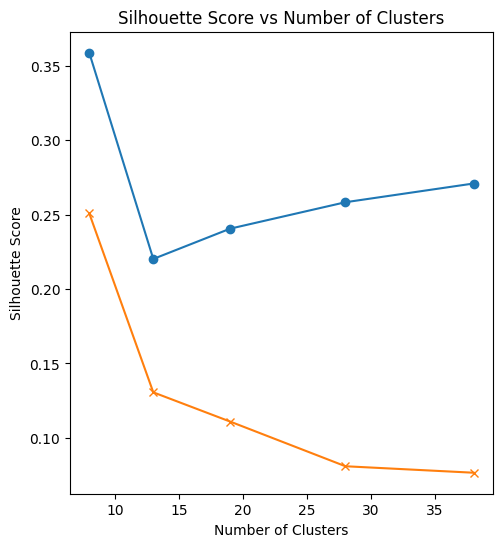

In [13]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(Ks, means_score, marker='o', label='Mean Data')
plt.plot(Ks, reduce_score, marker='x', label='PCA Data')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.show()

From the plot, we see that the silhouette score is higher for the mean data compared to the PCA data. This indicates that the mean data is more suitable for clustering compared to the PCA data. The silhouette score is highest for 38 clusters in mean data case while the highest for 8 clusters in the PCA data case.

## Inertia vs Number of Clusters

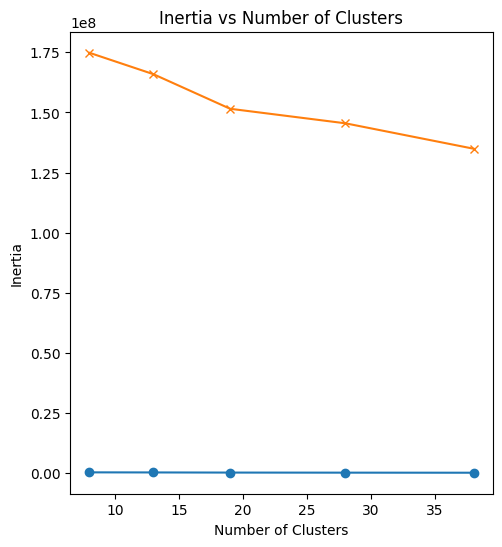

In [14]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(Ks, means_inertia, marker='o', label='Mean Data')
plt.plot(Ks, reduce_inertia, marker='x', label='PCA Data')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Inertia vs Number of Clusters')
plt.show()

From the plot, we see that the inertia is higher for the PCA data compared to the mean data. This indicates that the mean data is more suitable for clustering compared to the PCA data. The inertia is highest for eight clusters in both cases.

# Conclusion

We observed that the mean data is more suitable for clustering compared to the PCA data because of the following:
1- The silhouette score is higher for the mean data compared to the PCA data.
2- The inertia is lower for the mean data compared to the PCA data.

# Evaluation

## Purity

In [15]:
# Training data + Means approach
print("Training data + Means approach")
for K in Ks:
    kmeans = Kmeans(n_clusters=K)
    kmeans.fit(training_data_means)
    print(f'# clusters = {K}:', compute_purity(compute_clusters(training_labels, kmeans.clusters, K), len(training_data_means)))
    
# Training data + PCA approach
print("Training data + PCA approach")
for K in Ks:
    kmeans = Kmeans(n_clusters=K)
    kmeans.fit(PCA_training_data)
    print(f'# clusters = {K}:', compute_purity(compute_clusters(training_labels, kmeans.clusters, K), len(PCA_training_data)))
    
# Evaluation data + Means approach
print("Evaluation data + Means approach")
for K in Ks:
    kmeans = Kmeans(n_clusters=K)
    kmeans.fit(evaluation_data_means)
    print(f'# clusters = {K}:', compute_purity(compute_clusters(evaluation_labels, kmeans.clusters, K), len(evaluation_data_means)))
    
# Evaluation data + PCA approach
print("Evaluation data + PCA approach")
for K in Ks:
    kmeans = Kmeans(n_clusters=K)
    kmeans.fit(PCA_evaluation_data)
    print(f'# clusters = {K}:', compute_purity(compute_clusters(evaluation_labels, kmeans.clusters, K), len(PCA_evaluation_data)))

Training data + Means approach
# clusters = 8: 0.3279879385964912
# clusters = 13: 0.4076206140350877
# clusters = 19: 0.47341008771929827
# clusters = 28: 0.5235745614035088
# clusters = 38: 0.5630482456140351
Training data + PCA approach
# clusters = 8: 0.3086622807017544
# clusters = 13: 0.35759320175438597
# clusters = 19: 0.4805372807017544
# clusters = 28: 0.5379660087719298
# clusters = 38: 0.5441337719298246
Evaluation data + Means approach
# clusters = 8: 0.27521929824561403
# clusters = 13: 0.3744517543859649
# clusters = 19: 0.4155701754385965
# clusters = 28: 0.5449561403508771
# clusters = 38: 0.5581140350877193
Evaluation data + PCA approach
# clusters = 8: 0.2680921052631579
# clusters = 13: 0.3092105263157895
# clusters = 19: 0.37774122807017546
# clusters = 28: 0.43969298245614036
# clusters = 38: 0.49122807017543857


## Recall

In [16]:
# Training data + Means approach
print("Training data + Means approach")
for K in Ks:
    kmeans = Kmeans(n_clusters=K)
    kmeans.fit(training_data_means)
    print(f'# clusters = {K}:', compute_recall(compute_clusters(training_labels, kmeans.clusters, K), len(training_data_means)))
    
# Training data + PCA approach
print("Training data + PCA approach")
for K in Ks:
    kmeans = Kmeans(n_clusters=K)
    kmeans.fit(PCA_training_data)
    print(f'# clusters = {K}:', compute_recall(compute_clusters(training_labels, kmeans.clusters, K), len(PCA_training_data)))
    
# Evaluation data + Means approach
print("Evaluation data + Means approach")
for K in Ks:
    kmeans = Kmeans(n_clusters=K)
    kmeans.fit(evaluation_data_means)
    print(f'# clusters = {K}:', compute_recall(compute_clusters(evaluation_labels, kmeans.clusters, K), len(evaluation_data_means)))
    
# Evaluation data + PCA approach
print("Evaluation data + PCA approach")
for K in Ks:
    kmeans = Kmeans(n_clusters=K)
    kmeans.fit(PCA_evaluation_data)
    print(f'# clusters = {K}:', compute_recall(compute_clusters(evaluation_labels, kmeans.clusters, K), len(PCA_evaluation_data)))

Training data + Means approach
# clusters = 8: 0.8797350431743421
# clusters = 13: 0.6371713381761696
# clusters = 19: 0.5431015282346491
# clusters = 28: 0.3968006156341375
# clusters = 38: 0.32294950429459063
Training data + PCA approach
# clusters = 8: 0.9046891418813963
# clusters = 13: 0.7757297092013891
# clusters = 19: 0.6952354029605263
# clusters = 28: 0.5247220937271564
# clusters = 38: 0.4645706979851972
Evaluation data + Means approach
# clusters = 8: 0.7667214912280701
# clusters = 13: 0.6331551535087719
# clusters = 19: 0.5760747898391814
# clusters = 28: 0.5172126279239766
# clusters = 38: 0.38851768092105254
Evaluation data + PCA approach
# clusters = 8: 0.9238566794590644
# clusters = 13: 0.7623640807748538
# clusters = 19: 0.7323647660818712
# clusters = 28: 0.5577028508771931
# clusters = 38: 0.4880528143274853


## F1 Score

In [17]:
# Training data + Means approach
print("Training data + Means approach")
for K in Ks:
    kmeans = Kmeans(n_clusters=K)
    kmeans.fit(training_data_means)
    print(f'# clusters = {K}:', compute_f1(compute_clusters(training_labels, kmeans.clusters, K)))
    
# Training data + PCA approach
print("Training data + PCA approach")
for K in Ks:
    kmeans = Kmeans(n_clusters=K)
    kmeans.fit(PCA_training_data)
    print(f'# clusters = {K}:', compute_f1(compute_clusters(training_labels, kmeans.clusters, K)))
    
# Evaluation data + Means approach
print("Evaluation data + Means approach")
for K in Ks:
    kmeans = Kmeans(n_clusters=K)
    kmeans.fit(evaluation_data_means)
    print(f'# clusters = {K}:', compute_f1(compute_clusters(evaluation_labels, kmeans.clusters, K)))
    
# Evaluation data + PCA approach
print("Evaluation data + PCA approach")
for K in Ks:
    kmeans = Kmeans(n_clusters=K)
    kmeans.fit(PCA_evaluation_data)
    print(f'# clusters = {K}:', compute_f1(compute_clusters(evaluation_labels, kmeans.clusters, K)))

Training data + Means approach
# clusters = 8: 0.5437880872941433
# clusters = 13: 0.4958593172880389
# clusters = 19: 0.46947510663436764
# clusters = 28: 0.4178703011094366
# clusters = 38: 0.36638745995286065
Training data + PCA approach
# clusters = 8: 0.5184584942028571
# clusters = 13: 0.42423343766062493
# clusters = 19: 0.46020589602873213
# clusters = 28: 0.4040060094460064
# clusters = 38: 0.3221525855915172
Evaluation data + Means approach
# clusters = 8: 0.4085037139384505
# clusters = 13: 0.44855185791791974
# clusters = 19: 0.3980341720703979
# clusters = 28: 0.40747521442487683
# clusters = 38: 0.34843010205968994
Evaluation data + PCA approach
# clusters = 8: 0.3848286665742672
# clusters = 13: 0.33818524198522965
# clusters = 19: 0.32782832425031394
# clusters = 28: 0.3072829215976078
# clusters = 38: 0.284051616602323


## Conditional Entropy

In [18]:
# Training data + Means approach
print("Training data + Means approach")
for K in Ks:
    kmeans = Kmeans(n_clusters=K)
    kmeans.fit(training_data_means)
    print(f'# clusters = {K}:', compute_entropy(compute_clusters(training_labels, kmeans.clusters, K), len(training_data_means)))
    
# Training data + PCA approach
print("Training data + PCA approach")
for K in Ks:
    kmeans = Kmeans(n_clusters=K)
    kmeans.fit(PCA_training_data)
    print(f'# clusters = {K}:', compute_entropy(compute_clusters(training_labels, kmeans.clusters, K), len(PCA_training_data)))
    
# Evaluation data + Means approach
print("Evaluation data + Means approach")
for K in Ks:
    kmeans = Kmeans(n_clusters=K)
    kmeans.fit(evaluation_data_means)
    print(f'# clusters = {K}:', compute_entropy(compute_clusters(evaluation_labels, kmeans.clusters, K), len(evaluation_data_means)))
    
# Evaluation data + PCA approach
print("Evaluation data + PCA approach")
for K in Ks:
    kmeans = Kmeans(n_clusters=K)
    kmeans.fit(PCA_evaluation_data)
    print(f'# clusters = {K}:', compute_entropy(compute_clusters(evaluation_labels, kmeans.clusters, K), len(PCA_evaluation_data)))

Training data + Means approach
# clusters = 8: 2.457290605015856
# clusters = 13: 2.2102921038422467
# clusters = 19: 1.934487866581744
# clusters = 28: 1.6361391621300534
# clusters = 38: 1.441075298568206
Training data + PCA approach
# clusters = 8: 2.4595164750992655
# clusters = 13: 2.3144107896507724
# clusters = 19: 1.941594175356723
# clusters = 28: 1.7257213836228364
# clusters = 38: 1.6776122696815992
Evaluation data + Means approach
# clusters = 8: 2.5858441193469544
# clusters = 13: 2.182752342912512
# clusters = 19: 1.9191746523852296
# clusters = 28: 1.567984982877335
# clusters = 38: 1.4282460529955816
Evaluation data + PCA approach
# clusters = 8: 2.6168910918310724
# clusters = 13: 2.443865096510289
# clusters = 19: 2.1938013707753443
# clusters = 28: 1.9909577222294312
# clusters = 38: 1.7604400983784387
